Collaborators: Margaux Masson-Forsythe

## Imports 

In [30]:
# !pip install Hub && pip install wget

In [2]:
import tensorflow as tf
from hub import Dataset
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
print(tf.__version__)
# check if notebook is using GPU
tf.test.gpu_device_name()
import wget

2.4.0


## Load data

In [3]:
print("Load data from ActiveLoop ...")

tag15 = "margauxmforsythe/Senegal_histograms_weeks_19_30_departments_2015"
tag16 = "margauxmforsythe/Senegal_histograms_weeks_19_30_departments_2016"
tag17 = "margauxmforsythe/Senegal_histograms_weeks_19_30_departments_2017"
tag18 = "margauxmforsythe/Senegal_histograms_weeks_19_30_departments_2018"
histograms = np.concatenate((Dataset(tag15)["histograms"].compute(), 
                            Dataset(tag16)["histograms"].compute(),
                            Dataset(tag17)["histograms"].compute(),
                            Dataset(tag18)["histograms"].compute()), axis=0)

print("Dataset shape of histograms: {}".format(histograms[0].shape))
image_count = histograms.shape[0]
print("There are {} histograms in this dataset".format(image_count))

Load data from ActiveLoop ...
Dataset shape of histograms: (32, 11, 9)
There are 180 histograms in this dataset


Prepare data for CNN-LSTM model

In [4]:
# histograms_ActiveLoop = ds["histograms"].compute()
histograms_CNN_LSTM = []
for i in range(image_count):
  histogram_all_timestamps_transposed = np.transpose(histograms[i], (1,0,2))
  timestamps = []
  for j in range(histograms[i].shape[1]): # going through all timestamps
    timestamps.append(np.expand_dims(histogram_all_timestamps_transposed[j], axis=0))
  histograms_CNN_LSTM.append(timestamps)
histograms = histograms_CNN_LSTM
input_shape_cnn = histograms[0][0].shape
print(input_shape_cnn)
input_shape_cnn_lstm = (len(histograms[0]),) + input_shape_cnn
print(input_shape_cnn_lstm)

(1, 32, 9)
(11, 1, 32, 9)


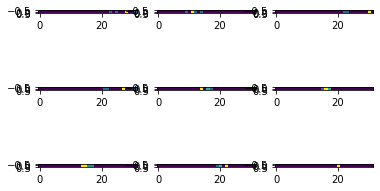

In [5]:
import matplotlib.pyplot as plt
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(histograms[0][0][:,:,i])

In [6]:
test_ds = tf.data.Dataset.from_tensor_slices(histograms)
test_ds = test_ds.batch(len(test_ds))
test_ds

<BatchDataset shapes: (None, 11, 1, 32, 9), types: tf.float64>

In [7]:
# names = np.load("/content/names_2015-01-01_2016-01-01.npy")
names = ['dakar', 'guediawaye', 'pikine', 'rufisque', 'bambey', 'diourbel', 'mbacke',
 'fatick', 'foundiougne', 'gossas', 'birkilane', 'kaffrine', 'koungheul',
 'maleme hodar', 'guinguineo', 'kaolack', 'nioro du rip', 'kedougou',
 'salemata', 'saraya', 'kolda', 'medina yoro foula', 'velingara', 'kebemer',
 'linguere', 'louga', 'kanel', 'matam', 'ranerou ferlo', 'dagana', 'podor',
 'saint-louis', 'bounkiling', 'goudomp', 'sedhiou', 'bakel', 'goudiry', 'koupentoum',
 'tambacounda', 'mbour', 'thies', 'tivaouane', 'bignona', 'oussouye',
 'ziguinchor']

print(names)
print(len(names))

['dakar', 'guediawaye', 'pikine', 'rufisque', 'bambey', 'diourbel', 'mbacke', 'fatick', 'foundiougne', 'gossas', 'birkilane', 'kaffrine', 'koungheul', 'maleme hodar', 'guinguineo', 'kaolack', 'nioro du rip', 'kedougou', 'salemata', 'saraya', 'kolda', 'medina yoro foula', 'velingara', 'kebemer', 'linguere', 'louga', 'kanel', 'matam', 'ranerou ferlo', 'dagana', 'podor', 'saint-louis', 'bounkiling', 'goudomp', 'sedhiou', 'bakel', 'goudiry', 'koupentoum', 'tambacounda', 'mbour', 'thies', 'tivaouane', 'bignona', 'oussouye', 'ziguinchor']
45


## Model

In [8]:
# CNN-LSTM 
# https://www.mdpi.com/1424-8220/19/20/4363/htm
from keras.layers.wrappers import TimeDistributed
from keras.layers import *
from keras import regularizers
model=models.Sequential()

model.add(TimeDistributed(Conv2D(32, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001),
                                  input_shape=(input_shape_cnn)), input_shape=input_shape_cnn_lstm))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Conv2D(64, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=True, activation='relu', dropout=0.25));

model.add(TimeDistributed(Dense(64)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(1)))
model.add(GlobalAveragePooling1D(name="global_avg_flow"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 11, 1, 31, 32)     608       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 1, 31, 32)     128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 1, 15, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 1, 14, 64)     4160      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 11, 1, 14, 64)     256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 11, 1, 7, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 11, 448)           0

In [9]:
initial_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name='RMSE'), tf.keras.losses.MeanSquaredError(name='MSE')])

## Maize

In [10]:
wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN_LSTM/checkpoint_maize_b16_CNN-LSTM.h5", "./checkpoint-maize.h5")

'./checkpoint-maize.h5'

In [11]:
model.load_weights("./checkpoint-maize.h5")

In [12]:
predictions = model.predict(test_ds)
i = 0
i_names = 0
year = 2015
years = []

indexes = []
yield_years = []
department_names = []
prediction_locations = []
yields_predicted = []

for prediction in predictions:
  indexes.append(i)
  years.append(year)
  department_names.append(names[i_names].split("-")[-1])
  # print("prediction {} for department: {} is {}".format(year, names[i_names].split("-")[-1], prediction[0]))
  prediction_locations.append(prediction[0])
  yields_predicted.append(prediction[0])
  i = i + 1
  i_names = i_names + 1
  if i_names == len(names):
    i_names = 0
    year = year + 1
    yield_years.append(yields_predicted)
    yields_predicted = []

i

180

In [13]:
print(len(yield_years)) # number of years 
print(len(yield_years[0])) # number of departments 
df_years = pd.DataFrame(yield_years, columns=department_names[0:45], index=[2015,2016,2017,2018])
df_years = df_years.T
df_years.head(15)


4
45


,2015,2016,2017,2018
dakar,0.513722,0.454306,0.670732,0.116870
guediawaye,0.589863,0.557507,0.722599,0.553042
pikine,1.058214,1.196911,1.370633,0.970550
rufisque,0.770421,1.054813,0.860077,1.273645
bambey,0.834818,0.515306,1.325377,0.775258
diourbel,0.953486,0.617910,0.912604,0.714598
mbacke,1.138080,0.851677,1.302282,0.682192
fatick,0.552395,0.026315,0.825908,0.042746
foundiougne,0.420832,0.405375,1.118739,1.130413
gossas,1.010448,0.834225,1.113936,1.225333


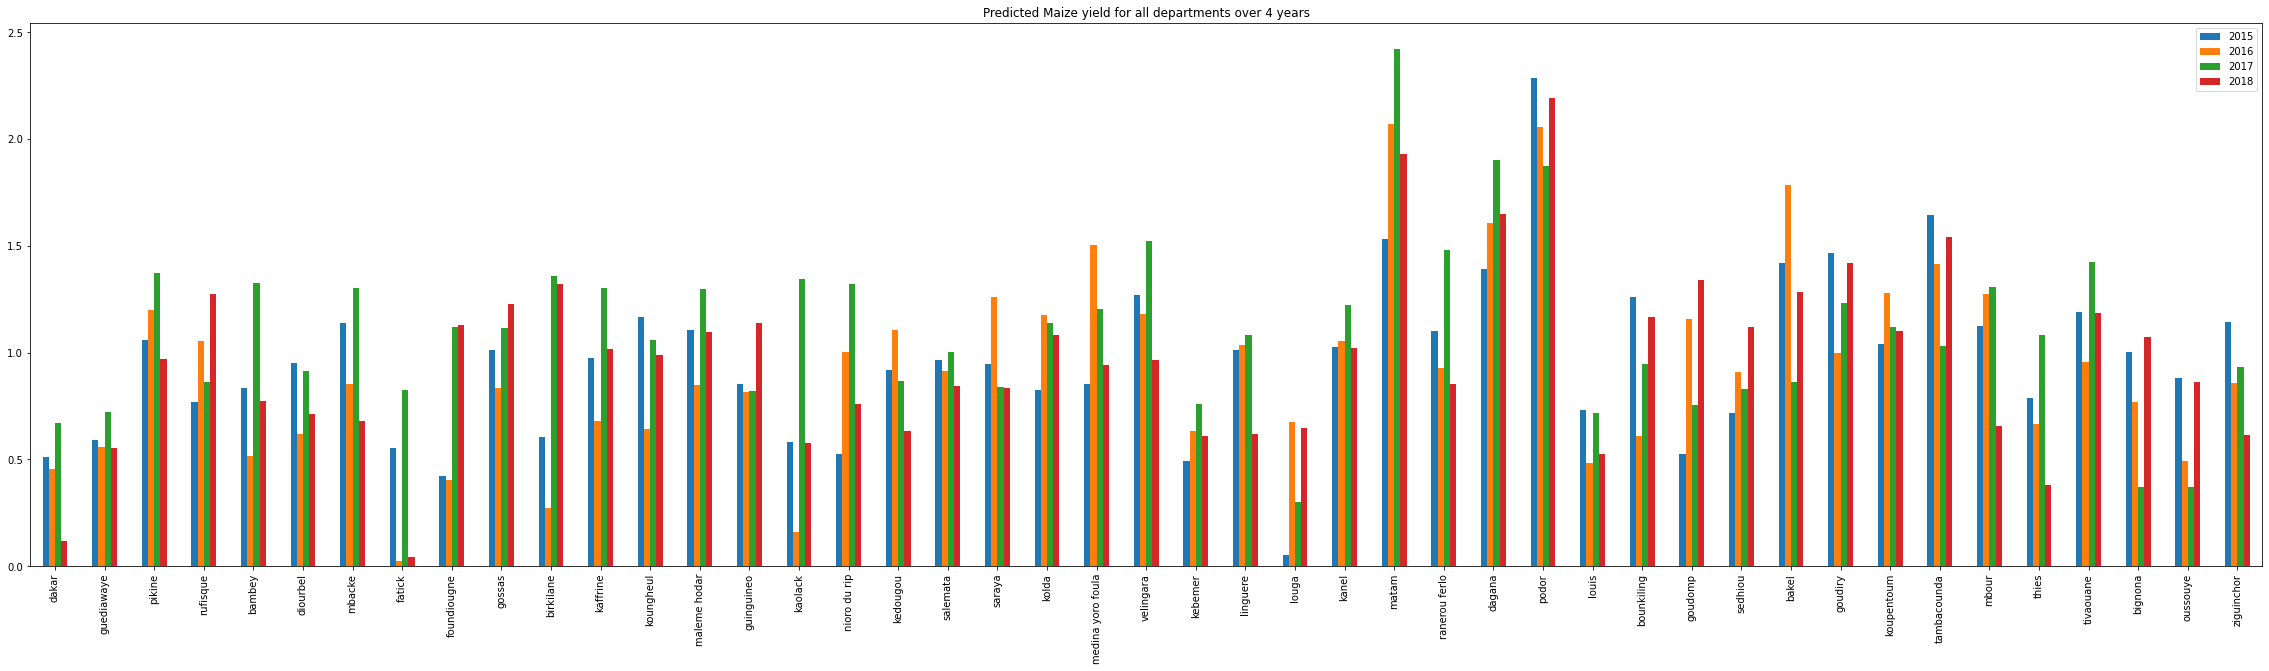

In [14]:
df_years.plot.bar(figsize=(40, 10), title="Predicted Maize yield for all departments over 4 years")

### Comparison with yield data from reports (not really helpful actually)

In [18]:
wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/yields_ground_truth_csv_files/senegal_yields_standardized_departments.csv", "senegal_yields_standardized_departments.csv")
df_real_yields = pd.read_csv('/content/senegal_yields_standardized_departments.csv')
df_real_yields.head(20)

,Region_main,Region,Year,Crop,Area,Production,Yield,Total_area,percentageion
0,DAKAR,Rufisque,2014,Arachide,2943.0,589,0.200136,130000,2.263846
1,DAKAR,Rufisque,2015,Arachide,1233.0,935,0.758313,130000,0.948462
2,DAKAR,Rufisque,2016,Arachide,1248.0,257,0.205929,130000,0.960000
3,DAKAR,Rufisque,2014,Cowpea,1178.0,177,0.150255,130000,0.906154
4,DAKAR,Rufisque,2015,Cowpea,858.0,397,0.462704,130000,0.660000
5,DAKAR,Rufisque,2016,Cowpea,1248.0,366,0.293269,130000,0.960000
6,DAKAR,Rufisque,2014,Corn,900.0,585,0.650000,130000,0.692308
7,DAKAR,Rufisque,2015,Corn,900.0,799,0.887778,130000,0.692308
8,DAKAR,Rufisque,2016,Corn,990.0,836,0.844444,130000,0.761538
9,DAKAR,Rufisque,2014,Sorghum,200.0,90,0.450000,130000,0.153846


NumExpr defaulting to 2 threads.


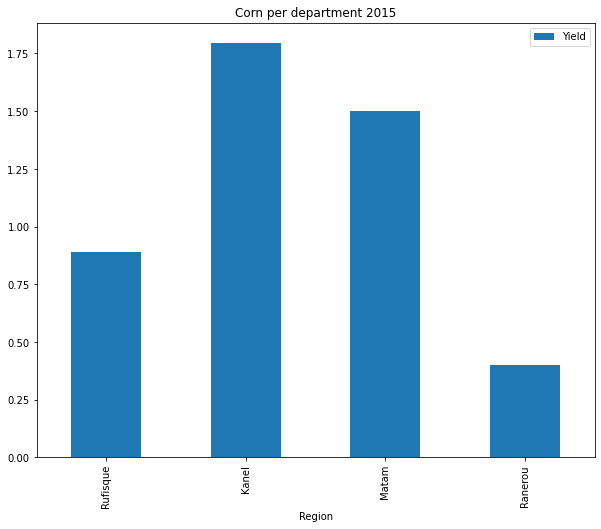

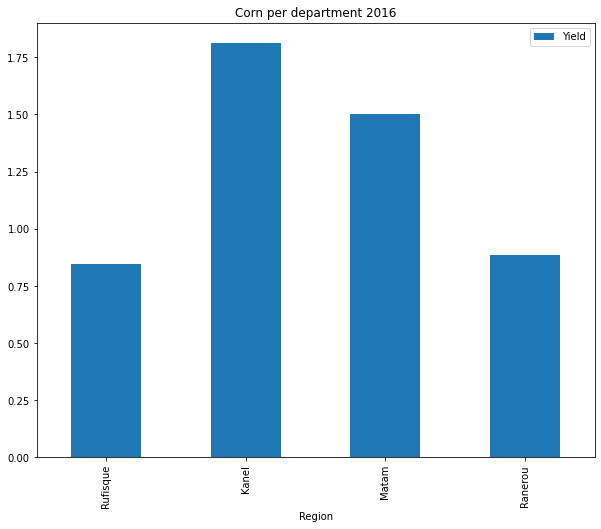

In [19]:
year = 2015
for year in [2015,2016]:
  df_real_yields_year = df_real_yields[df_real_yields["Year"] == year]
  df_real_yields_year_corn = df_real_yields_year[df_real_yields_year["Crop"] == "Corn"]
  df_real_yields_year_corn.plot.bar(x='Region', y="Yield", figsize=(10,8), title="Corn per department {}".format(year))

## Millet

In [20]:
wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN_LSTM/checkpoint_millet_b16_CNN-LSTM.h5", "./checkpoint-millet.h5")

'./checkpoint-millet.h5'

In [21]:
model.load_weights("./checkpoint-millet.h5")

In [22]:
predictions = model.predict(test_ds)
i = 0
i_names = 0
year = 2015
years = []

indexes = []
yield_years = []
department_names = []
prediction_locations = []
yields_predicted = []

for prediction in predictions:
  indexes.append(i)
  years.append(year)
  department_names.append(names[i_names].split("-")[-1])
  # print("prediction {} for department: {} is {}".format(year, names[i_names].split("-")[-1], prediction[0]))
  prediction_locations.append(prediction[0])
  yields_predicted.append(prediction[0])
  i = i + 1
  i_names = i_names + 1
  if i_names == len(names):
    i_names = 0
    year = year + 1
    yield_years.append(yields_predicted)
    yields_predicted = []

i

180

In [23]:
print(len(yield_years)) # number of years 
print(len(yield_years[0])) # number of departments 
df_years = pd.DataFrame(yield_years, columns=department_names[0:45], index=[2015,2016,2017,2018])
df_years = df_years.T
df_years.head(15)


4
45


,2015,2016,2017,2018
dakar,-0.705032,-0.708333,0.631149,-1.707480
guediawaye,0.560279,1.456616,0.469580,0.044702
pikine,0.623759,1.062381,0.799576,0.308463
rufisque,0.722629,0.869056,0.831820,0.473928
bambey,1.227561,0.907238,0.621340,0.890723
diourbel,1.228476,1.178850,0.453227,2.342441
mbacke,1.419615,1.231416,0.602654,1.905606
fatick,0.800207,0.410027,0.561727,1.040772
foundiougne,0.680135,0.735195,0.606423,0.423779
gossas,1.262318,0.960481,0.668611,1.808305


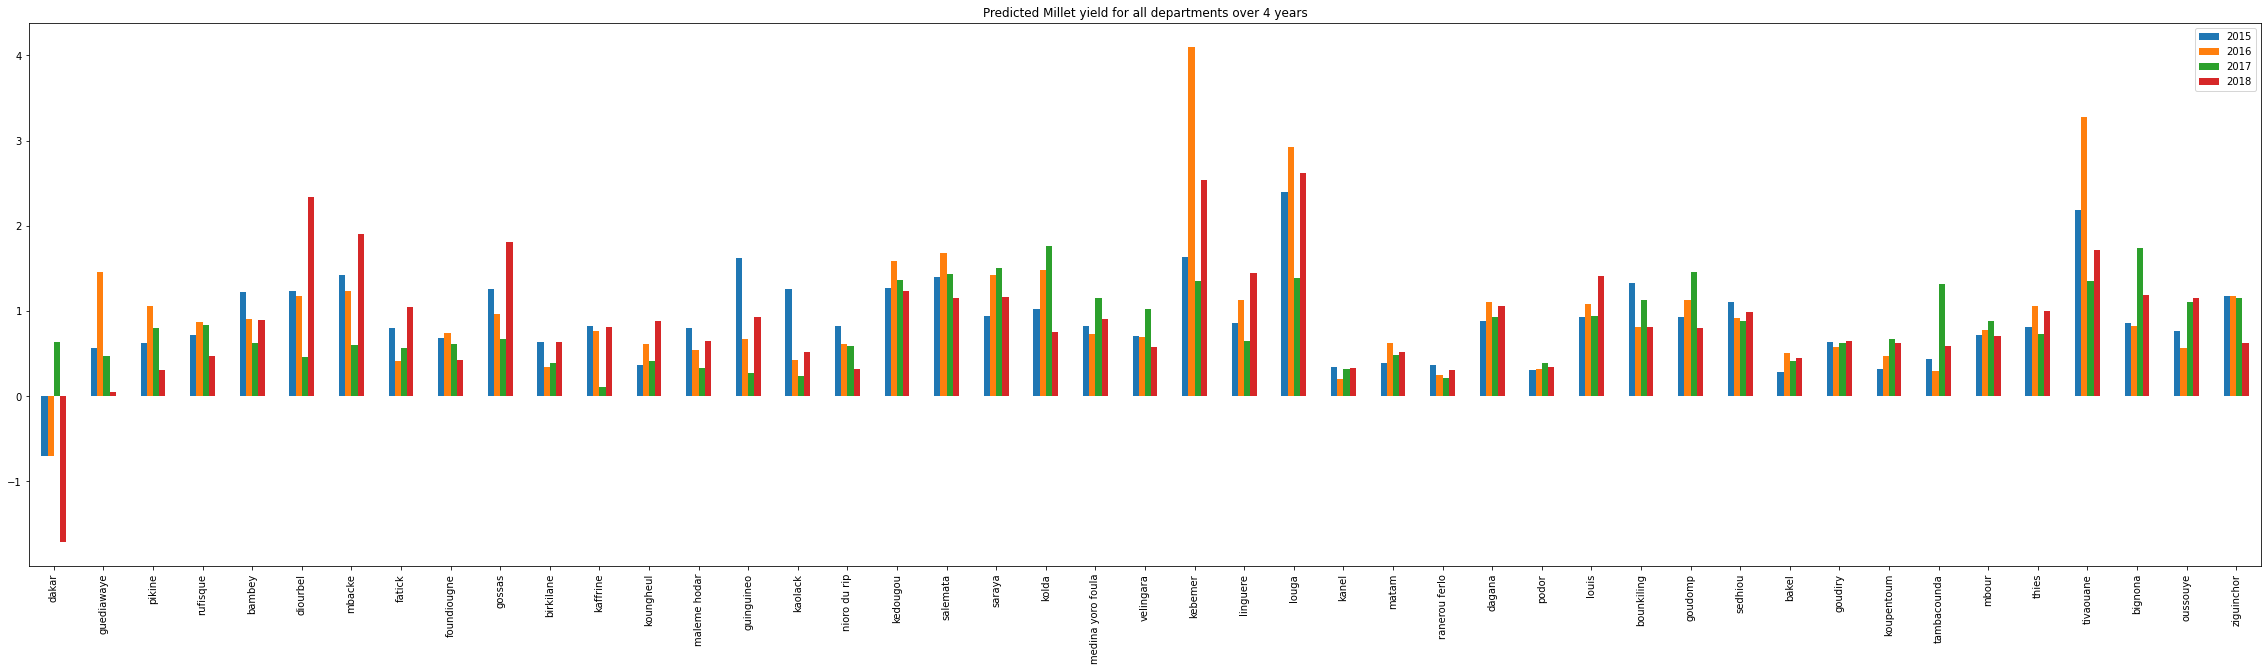

In [24]:
df_years.plot.bar(figsize=(40, 10), title="Predicted Millet yield for all departments over 4 years")

## Rice

In [25]:
wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN_LSTM/checkpoint_rice_b16_CNN-LSTM.h5", "./checkpoint-rice.h5")

'./checkpoint-rice.h5'

In [26]:
model.load_weights("./checkpoint-rice.h5")

In [27]:
predictions = model.predict(test_ds)
i = 0
i_names = 0
year = 2015
years = []

indexes = []
yield_years = []
department_names = []
prediction_locations = []
yields_predicted = []

for prediction in predictions:
  indexes.append(i)
  years.append(year)
  department_names.append(names[i_names].split("-")[-1])
  # print("prediction {} for department: {} is {}".format(year, names[i_names].split("-")[-1], prediction[0]))
  prediction_locations.append(prediction[0])
  yields_predicted.append(prediction[0])
  i = i + 1
  i_names = i_names + 1
  if i_names == len(names):
    i_names = 0
    year = year + 1
    yield_years.append(yields_predicted)
    yields_predicted = []

i

180

In [28]:
print(len(yield_years)) # number of years 
print(len(yield_years[0])) # number of departments 
df_years = pd.DataFrame(yield_years, columns=department_names[0:45], index=[2015,2016,2017,2018])
df_years = df_years.T
df_years.head(15)


4
45


,2015,2016,2017,2018
dakar,-0.474775,0.150106,0.799294,0.872997
guediawaye,0.128846,0.455806,-0.155451,0.641946
pikine,2.605500,2.861138,3.224143,3.132479
rufisque,3.210155,3.689034,3.817850,4.190147
bambey,2.784222,2.560380,3.250186,3.226130
diourbel,3.360084,2.795502,2.879396,3.842522
mbacke,2.549622,3.147962,2.493263,3.655541
fatick,1.973065,2.199924,2.184027,2.691195
foundiougne,1.771961,2.656144,1.502792,2.824728
gossas,2.331357,3.270945,2.613824,3.278526


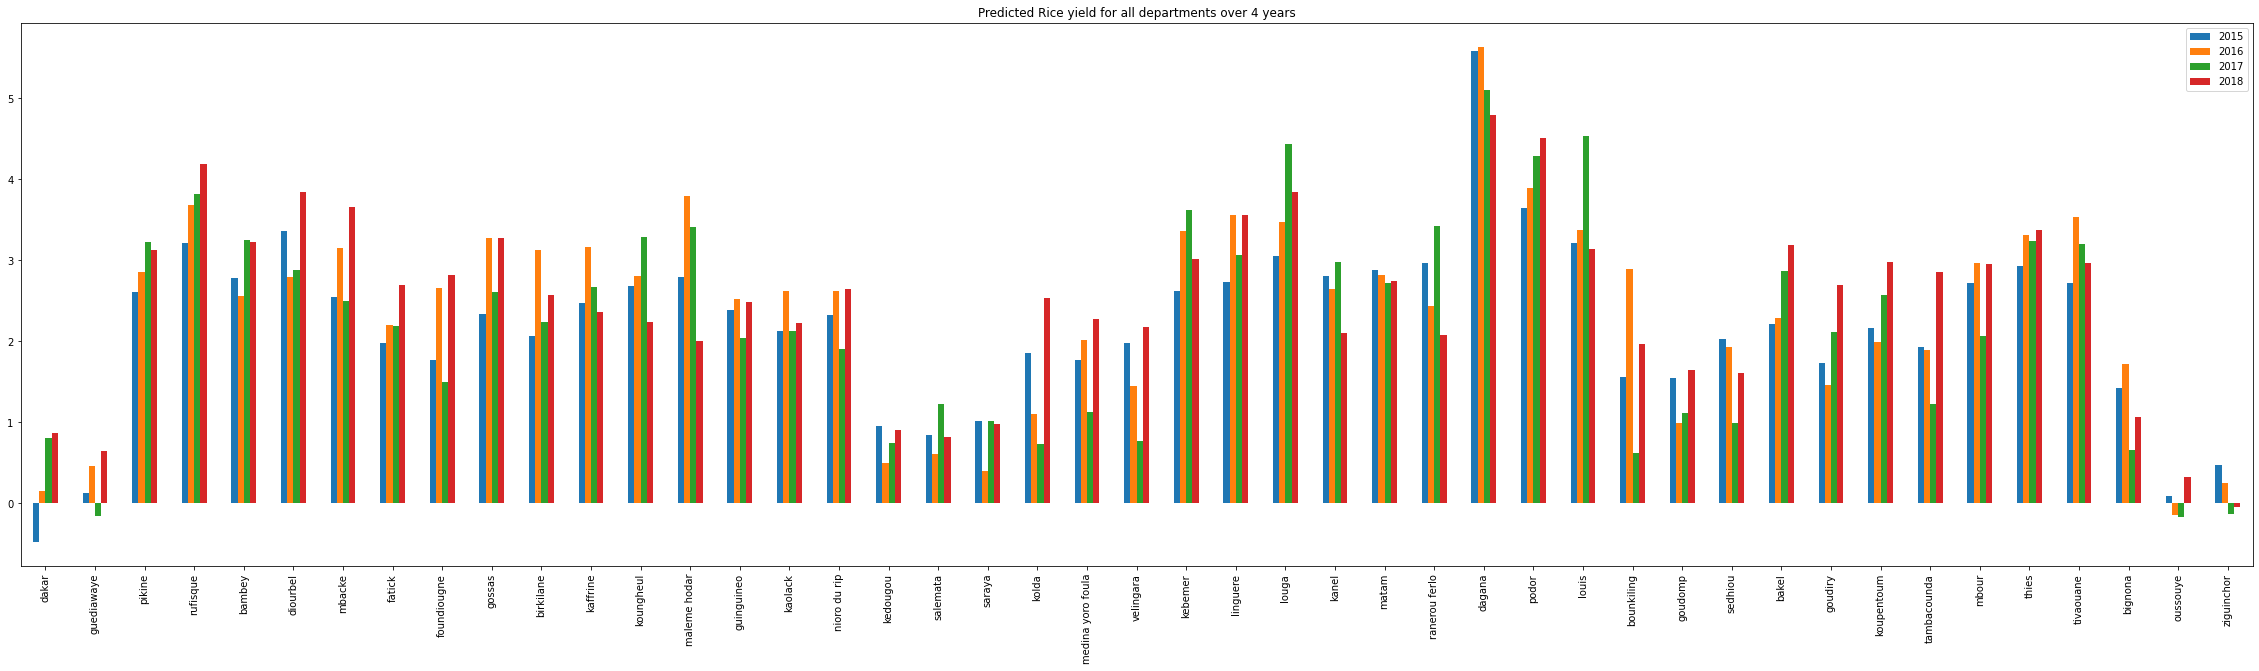

In [29]:
df_years.plot.bar(figsize=(40, 10), title="Predicted Rice yield for all departments over 4 years")